In [1]:
# Cell 1 — Imports & plotting defaults
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import plotly for interactive charts; fall back silently if not available
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,5)
sns.set_context("notebook")


In [2]:
# Cell 2 — Load NIFTY file & robust datetime parse
DATA_PATH = Path("Data/NIFTY_FUT.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Place NIFTY_FUT.csv at this location.")

df = pd.read_csv(DATA_PATH, dtype=str)
df.columns = [c.strip() for c in df.columns]

# normalize spacing and parse
df['datetime_raw'] = df['datetime'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

# numeric casts
for col in ['open','high','low','close','volume']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Rows loaded:", len(df))
print("Datetime parse failures (NaT):", df['datetime'].isna().sum())
df.head(6)


Rows loaded: 289483
Datetime parse failures (NaT): 173759


,datetime,tradingsymbol,expiry,open,high,low,close,volume,datetime_raw
0,2021-01-07 09:15:00,NIFTY21JULFUT,2021-07-29,15765.10,15769.00,15756.10,15761.75,71000.0,2021-07-01 09:15:00
1,2021-01-07 09:16:00,NIFTY21JULFUT,2021-07-29,15760.50,15763.85,15749.95,15757.70,62000.0,2021-07-01 09:16:00
2,2021-01-07 09:17:00,NIFTY21JULFUT,2021-07-29,15758.00,15762.00,15750.65,15751.50,34250.0,2021-07-01 09:17:00
3,2021-01-07 09:18:00,NIFTY21JULFUT,2021-07-29,15750.10,15750.65,15738.25,15743.60,146750.0,2021-07-01 09:18:00
4,2021-01-07 09:19:00,NIFTY21JULFUT,2021-07-29,15743.85,15746.75,15739.10,15745.50,30050.0,2021-07-01 09:19:00
5,2021-01-07 09:20:00,NIFTY21JULFUT,2021-07-29,15744.30,15746.00,15728.40,15733.00,48150.0,2021-07-01 09:20:00


In [3]:
# Cell 3 — EOD extraction logic (last tick <= 15:30)
EOD_CUTOFF = "15:30"
df = df.dropna(subset=['datetime']).copy()
df['sec_of_day'] = df['datetime'].dt.hour * 3600 + df['datetime'].dt.minute * 60 + df['datetime'].dt.second
df['cal_date'] = df['datetime'].dt.date
hh, mm = map(int, EOD_CUTOFF.split(":"))
cutoff_sec = hh * 3600 + mm * 60
df['market_date'] = pd.to_datetime(df['cal_date'])
after_mask = df['sec_of_day'] > cutoff_sec
df.loc[after_mask, 'market_date'] = df.loc[after_mask, 'market_date'] + pd.Timedelta(days=1)
df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{EOD_CUTOFF}:00")
valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()
idx = valid.groupby('market_date')['datetime'].idxmax()
eod = valid.loc[idx, ['market_date','datetime','open','high','low','close','volume']].copy()
eod['date'] = eod['market_date'].dt.date
eod = eod.sort_values('date').reset_index(drop=True)
print("EOD rows:", len(eod))
eod.head()


EOD rows: 311


,market_date,datetime,open,high,low,close,volume,date
0,2021-01-07,2021-01-07 15:29:00,15723.00,15727.15,15721.20,15727.00,45450.0,2021-01-07
1,2021-01-09,2021-01-09 15:29:00,17087.85,17089.00,17085.00,17086.25,47800.0,2021-01-09
2,2021-01-10,2021-01-10 15:29:00,17519.45,17527.00,17517.25,17525.75,45100.0,2021-01-10
3,2021-01-11,2021-01-11 15:29:00,18016.60,18019.75,18015.15,18017.00,76500.0,2021-01-11
4,2021-01-12,2021-01-12 15:29:00,17226.35,17237.25,17226.00,17235.00,54450.0,2021-01-12


In [4]:
# Cell 4 — Compute indicators (on close)
series = eod[['date','open','high','low','close','volume']].copy()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').asfreq('D')   # calendar index for nicer plotting
series['close'] = pd.to_numeric(series['close'], errors='coerce').ffill()
series['open']  = pd.to_numeric(series['open'], errors='coerce').ffill()
series['high']  = pd.to_numeric(series['high'], errors='coerce').ffill()
series['low']   = pd.to_numeric(series['low'], errors='coerce').ffill()
series['volume'] = pd.to_numeric(series['volume'], errors='coerce').fillna(0)

# Bollinger Bands
window = 20
series['ma20'] = series['close'].rolling(window).mean()
series['std20'] = series['close'].rolling(window).std()
series['bb_up'] = series['ma20'] + 2 * series['std20']
series['bb_dn'] = series['ma20'] - 2 * series['std20']

# MACD (12,26) + signal(9)
exp1 = series['close'].ewm(span=12, adjust=False).mean()
exp2 = series['close'].ewm(span=26, adjust=False).mean()
series['macd'] = exp1 - exp2
series['macd_signal'] = series['macd'].ewm(span=9, adjust=False).mean()
series['macd_hist'] = series['macd'] - series['macd_signal']

# RSI (14)
delta = series['close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
roll_up = up.ewm(com=14-1, adjust=False).mean()
roll_down = down.ewm(com=14-1, adjust=False).mean()
rs = roll_up / roll_down
series['rsi_14'] = 100.0 - (100.0 / (1.0 + rs))

# returns
series['returns'] = series['close'].pct_change()
series['vol_14'] = series['returns'].rolling(14).std() * math.sqrt(252)

series.tail(6)


,open,high,low,close,volume,ma20,std20,bb_up,bb_dn,macd,macd_signal,macd_hist,rsi_14,returns,vol_14
date,,,,,,,,,,,,,,,
2025-09-26,23665.85,23671.50,23665.0,23671.1,0.0,23671.100,0.000000,23671.100000,23671.100000,-12.951427,-16.740449,3.789022,0.523683,0.000000,0.000000
2025-09-27,23665.85,23671.50,23665.0,23671.1,0.0,23671.100,0.000000,23671.100000,23671.100000,-12.101196,-15.812598,3.711402,0.523683,0.000000,0.000000
2025-09-28,23665.85,23671.50,23665.0,23671.1,0.0,23671.100,0.000000,23671.100000,23671.100000,-11.297155,-14.909510,3.612354,0.523683,0.000000,0.000000
2025-09-29,23665.85,23671.50,23665.0,23671.1,0.0,23671.100,0.000000,23671.100000,23671.100000,-10.538466,-14.035301,3.496835,0.523683,0.000000,0.000000
2025-09-30,23665.85,23671.50,23665.0,23671.1,0.0,23671.100,0.000000,23671.100000,23671.100000,-9.823955,-13.193032,3.369076,0.523683,0.000000,0.000000
2025-10-01,23509.60,23519.35,23509.2,23515.0,42275.0,23663.295,34.905021,23733.105042,23593.484958,-21.604621,-14.875350,-6.729272,0.036210,-0.006595,0.027978


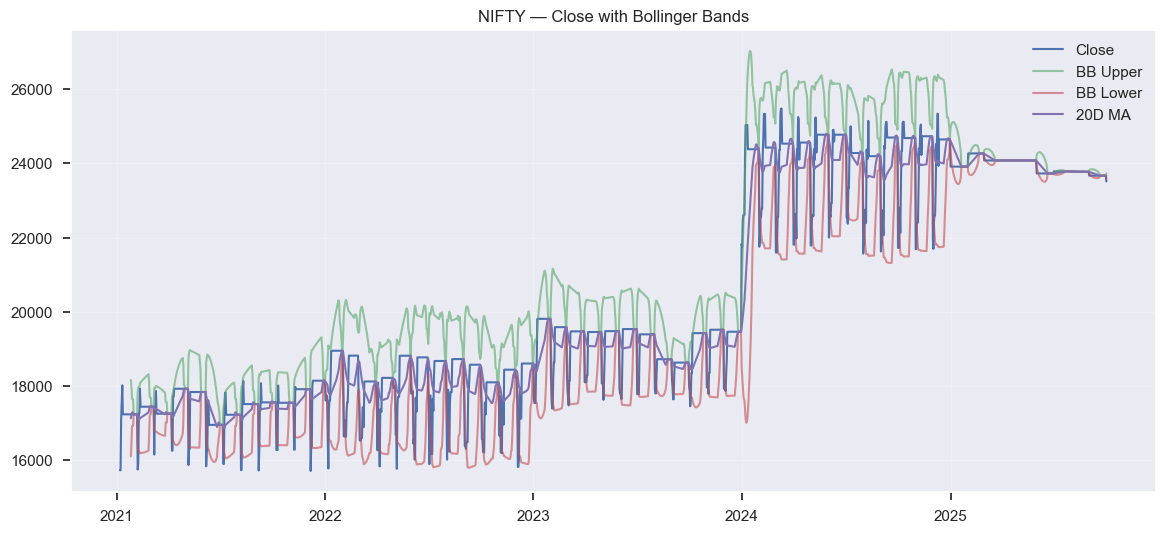

In [5]:
# Cell 5 — Price + Bollinger Bands (interactive if plotly available)
if PLOTLY_AVAILABLE:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series['close'], name='Close', line=dict(width=1.5)))
    fig.add_trace(go.Scatter(x=series.index, y=series['bb_up'], name='BB Upper', line=dict(width=1), opacity=0.6))
    fig.add_trace(go.Scatter(x=series.index, y=series['bb_dn'], name='BB Lower', line=dict(width=1), opacity=0.6))
    fig.add_trace(go.Scatter(x=series.index, y=series['ma20'], name='20D MA', line=dict(width=1), opacity=0.8))
    fig.update_layout(title='NIFTY — Close with Bollinger Bands', xaxis_title='Date', yaxis_title='Price', height=500)
    fig.show()
else:
    plt.figure(figsize=(14,6))
    plt.plot(series.index, series['close'], label='Close')
    plt.plot(series.index, series['bb_up'], label='BB Upper', alpha=0.6)
    plt.plot(series.index, series['bb_dn'], label='BB Lower', alpha=0.6)
    plt.plot(series.index, series['ma20'], label='20D MA')
    plt.title('NIFTY — Close with Bollinger Bands')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


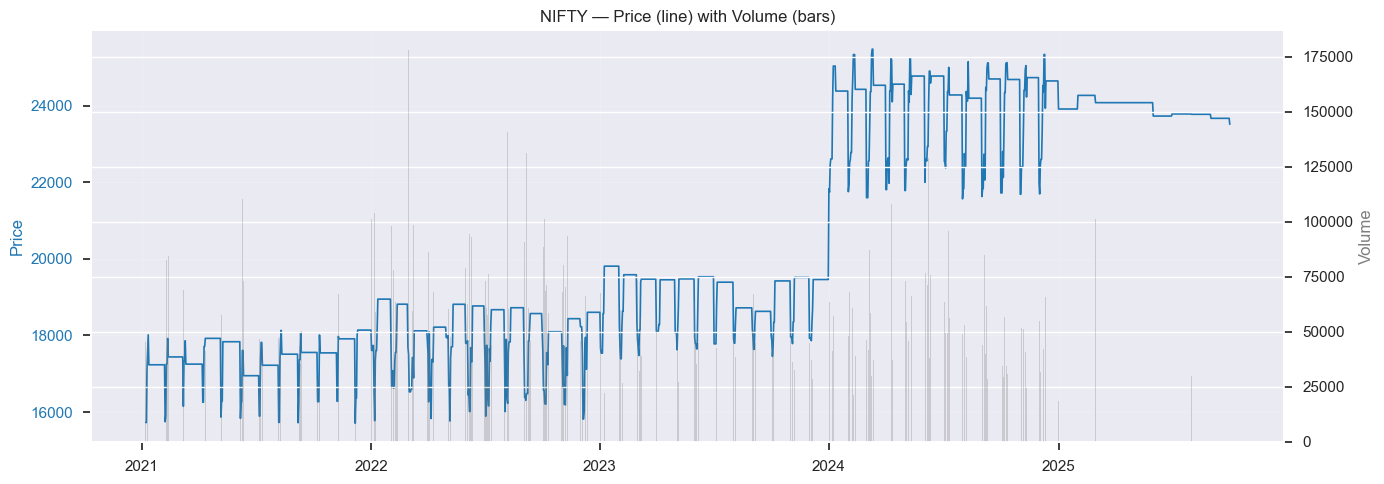

In [6]:
# Cell 6 — Volume bars + price line (Matplotlib)
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(series.index, series['close'], color='tab:blue', label='Close', linewidth=1.2)
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.bar(series.index, series['volume'], color='tab:gray', alpha=0.3, label='Volume')
ax2.set_ylabel('Volume', color='tab:gray')
plt.title('NIFTY — Price (line) with Volume (bars)')
ax1.grid(alpha=0.15)
fig.tight_layout()
plt.show()


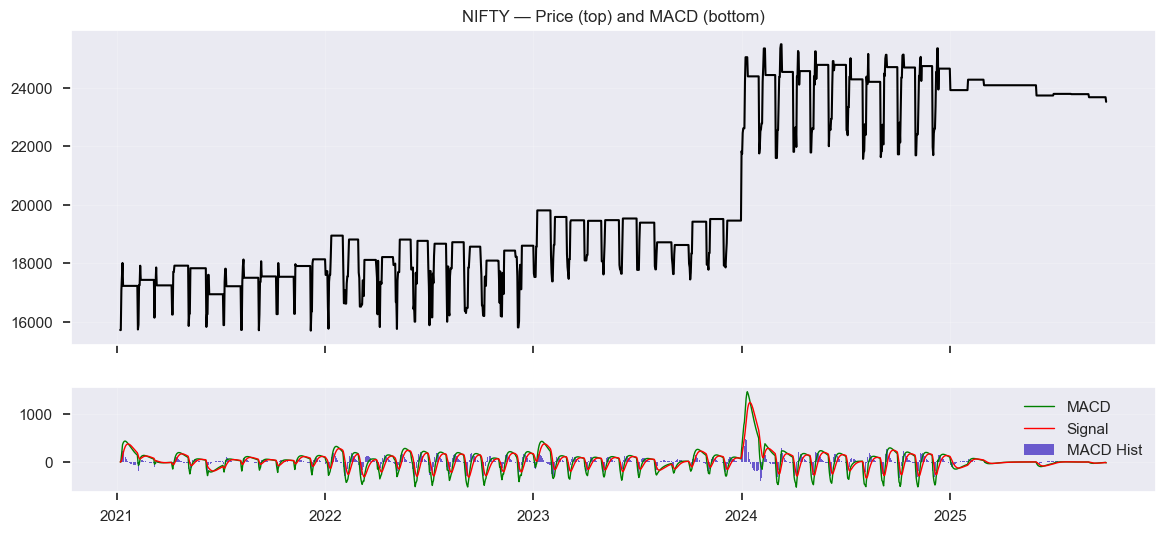

In [7]:
# Cell 7 — MACD plot (Matplotlib)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,6), gridspec_kw={'height_ratios':[3,1]}, sharex=True)
ax1.plot(series.index, series['close'], label='Close', color='black')
ax1.set_title('NIFTY — Price (top) and MACD (bottom)')
ax2.bar(series.index, series['macd_hist'], label='MACD Hist', color='slateblue')
ax2.plot(series.index, series['macd'], label='MACD', color='green', linewidth=1)
ax2.plot(series.index, series['macd_signal'], label='Signal', color='red', linewidth=1)
ax2.legend()
ax1.grid(alpha=0.2); ax2.grid(alpha=0.2)
plt.show()


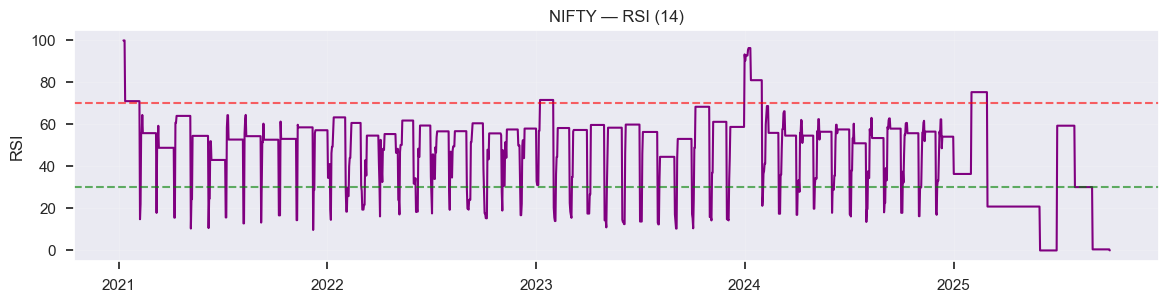

In [8]:
# Cell 8 — RSI
plt.figure(figsize=(14,3))
plt.plot(series.index, series['rsi_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.6)
plt.axhline(30, color='green', linestyle='--', alpha=0.6)
plt.title('NIFTY — RSI (14)')
plt.ylabel('RSI')
plt.grid(alpha=0.15)
plt.show()


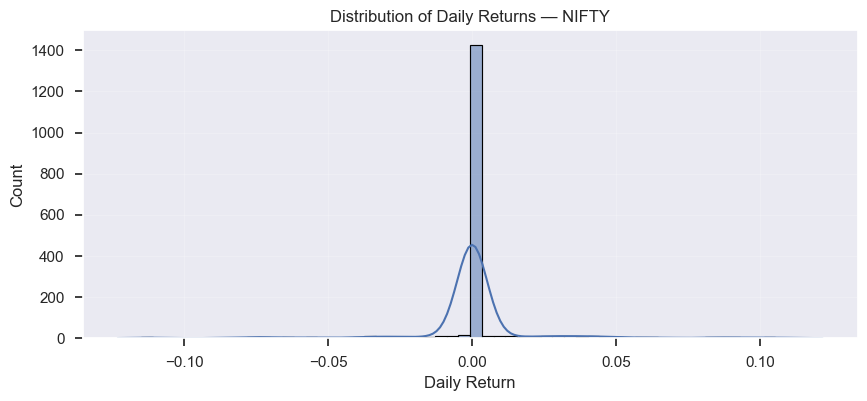

In [9]:
# Cell 9 — Return distribution (hist + KDE)
ret = series['returns'].dropna()
plt.figure(figsize=(10,4))
sns.histplot(ret, bins=60, kde=True)
plt.title('Distribution of Daily Returns — NIFTY')
plt.xlabel('Daily Return')
plt.grid(alpha=0.2)
plt.show()


In [11]:
# Cell 11 — Small text summary (top metrics)
latest = series['close'].dropna().iloc[-1]
ytd_change = series['close'].dropna().iloc[-1] / series['close'].dropna().iloc[0] - 1.0
vol_recent = series['vol_14'].dropna().iloc[-1]

print("NIFTY summary")
print("Latest price:", round(latest,2))
print("Total period change:", f"{ytd_change*100:.2f}%")
print("Recent annualized vol (14d):", f"{vol_recent:.2f}")


NIFTY summary
Latest price: 23515.0
Total period change: 49.52%
Recent annualized vol (14d): 0.03


In [12]:
# Cell 12 — Optional baseline demo (safe & small)
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    df_tab = series[['close']].copy().reset_index().rename(columns={'index':'date'})
    for lag in range(1,6):   # small 5-lag model for demo (keeps it quick)
        df_tab[f'lag_{lag}'] = df_tab['close'].shift(lag)
    df_tab = df_tab.dropna().reset_index(drop=True)
    X = df_tab[[f'lag_{l}' for l in range(1,6)]].values
    y = df_tab['close'].shift(-1).ffill().values
    if len(X) < 80:
        print("Not enough rows for baseline demo; skipping.")
    else:
        split = int(len(X)*0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = mean_squared_error(y_test, preds) ** 0.5
        print("Baseline (5-lag) MAE:", round(mae,2))
        print("Baseline (5-lag) RMSE:", round(rmse,2))
except Exception as e:
    print("Baseline skipped (sklearn missing or error):", e)


Baseline (5-lag) MAE: 438.14
Baseline (5-lag) RMSE: 549.33


In [13]:
# Cell 13 — Instructions to export (for embedding)
print("NIFTY showcase ready. To export HTML for React embedding:")
print("jupyter nbconvert --to html your_notebook_filename.ipynb --output public/notebooks/nifty_showcase.html")


NIFTY showcase ready. To export HTML for React embedding:
jupyter nbconvert --to html your_notebook_filename.ipynb --output public/notebooks/nifty_showcase.html
